# Parte 2: Detección de caras

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.applications import DenseNet121
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras import backend as K
from keras import optimizers
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import Image
import cv2
import json
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("icml_face_data.csv")

In [3]:
def string2array(x):
  return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

In [4]:
def resize(x):
  img = x.reshape(48, 48)
  return cv2.resize(img, dsize=(96, 96), interpolation = cv2.INTER_CUBIC)

In [5]:
df[' pixels'] = df[' pixels'].apply(lambda x: string2array(x))
df[' pixels'] = df[' pixels'].apply(lambda x: resize(x))

In [6]:
df.shape

(24568, 2)

In [7]:
df.isnull().sum()

emotion    0
 pixels    0
dtype: int64

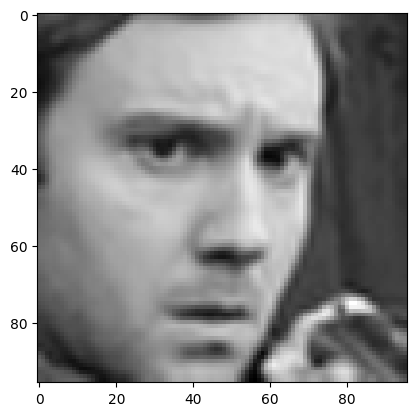

In [8]:
plt.imshow(df[' pixels'][0], cmap = 'gray')

In [9]:
label_to_text = {0:'Ira', 1:'Odio', 2:'Tristeza', 3:'Felicidad', 4: 'Sorpresa'}

In [10]:
data = df[df['emotion'] == 0]
img=data[' pixels'].iloc[0]

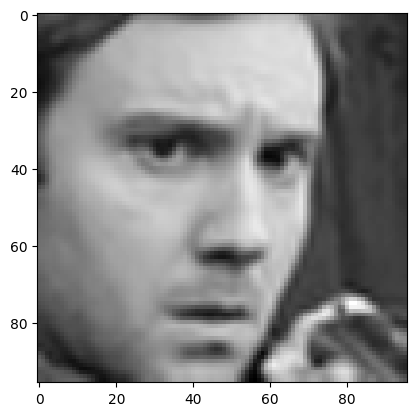

In [11]:
plt.imshow(img, cmap = 'gray')

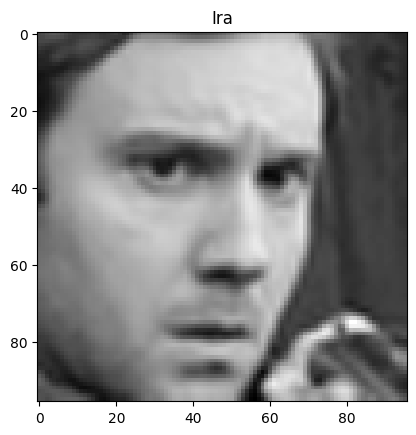

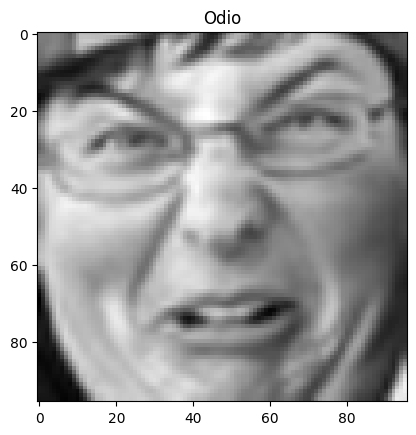

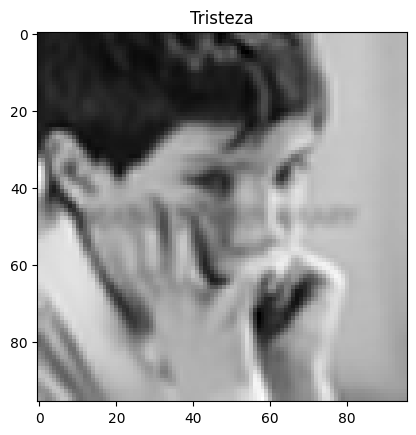

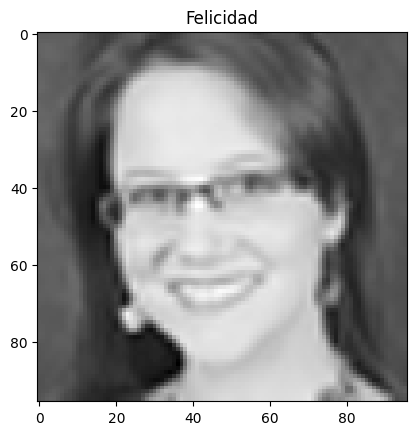

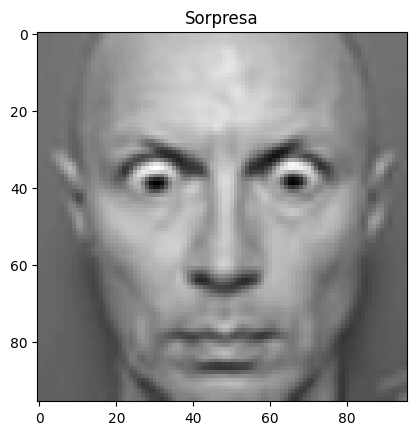

In [12]:
emotions = [0, 1, 2, 3, 4]

for i in emotions:
  data = df[df['emotion'] == i][:1]
  img = data[' pixels'].item()
  plt.figure()
  plt.title(label_to_text[i])
  plt.imshow(img, cmap = 'gray')

In [13]:
df.emotion.value_counts().index

Index([3, 2, 0, 4, 1], dtype='int64', name='emotion')

In [14]:
df.emotion.value_counts()

emotion
3    8989
2    6077
0    4953
4    4002
1     547
Name: count, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

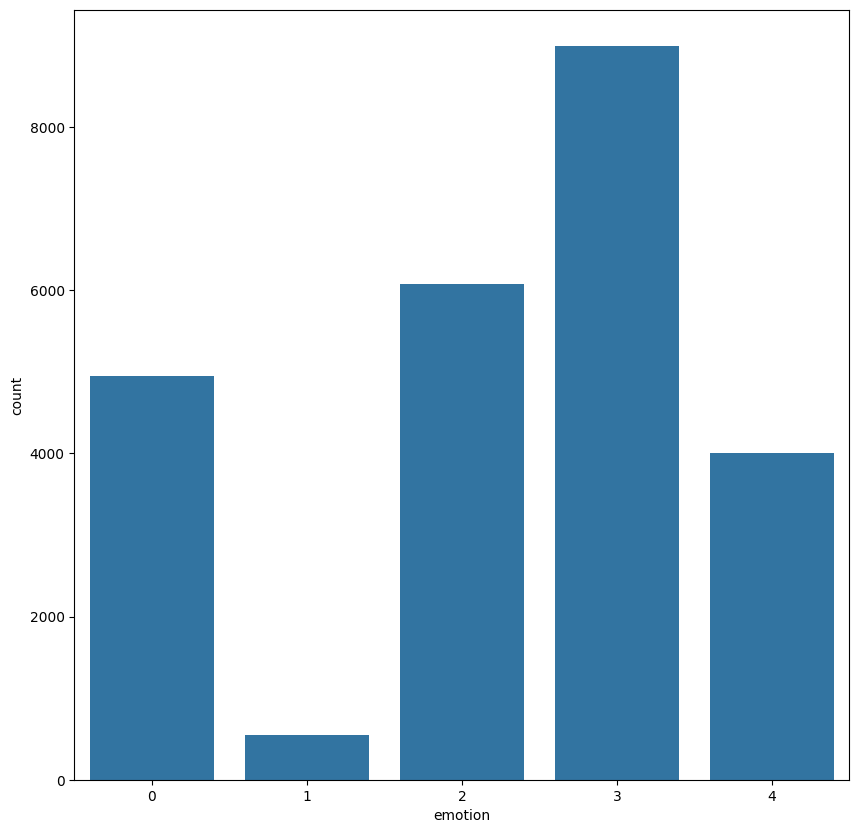

In [15]:
plt.figure(figsize = (10,10))
sns.barplot(x = df.emotion.value_counts().index, y = df.emotion.value_counts())

In [16]:
from keras.utils import to_categorical

img = df[' pixels']
print(img.shape)
y = to_categorical(df['emotion'])
print(y.shape)

(24568,)
(24568, 5)


In [17]:
# Creamos un array vacío de tamaño (x, 96, 96, 1) para subministrar al modelo

X = np.empty((len(img), 96, 96, 1))

# Iteramos sobre la lista de imágenes y añadimos las mismas al array vacío tras expandir su dimensión de (96, 96) a (96, 96, 1)
for i in range(len(X)):
  X[i,] = np.expand_dims(img[i], axis = 2)

# Convertimos el tipo array a float32
X = np.asarray(X).astype(np.float32)
X.shape

(24568, 96, 96, 1)

In [18]:
print(X.shape, y.shape)

(24568, 96, 96, 1) (24568, 5)


In [19]:
# Dividir el dataframe en conjunto de entrenamiento, test y validación

from sklearn.model_selection import train_test_split

X_train, X_Test, y_train, y_Test = train_test_split(X, y, test_size = 0.1, shuffle = True)
X_val, X_Test, y_val, y_Test = train_test_split(X_Test, y_Test, test_size = 0.5, shuffle = True)


In [20]:
# Pre Procesado de Imágenes

X_train = X_train/255.
X_val   = X_val /255.
X_Test  = X_Test/255.

In [21]:
train_datagen = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = [1.1, 1.5],
    fill_mode = "nearest")

In [22]:
def res_block(X, filter, stage):
  # Copia del tensor de entrada
  X_copy = X

  # Descomponer el filtro en f1, f2 y f3
  f1 , f2, f3 = filter

  # Camino Principal
  # Capa de convolución 1x1 seguida de Max Pooling, Batch Normalization y activación ReLU
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_conv_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = MaxPool2D((2,2))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_a')(X)
  X = Activation('relu')(X)

  # Capa de convolución 3x3 con relleno 'same', Batch Normalization y activación ReLU
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_conv_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_b')(X)
  X = Activation('relu')(X)

  # Capa de convolución 1x1, Batch Normalization
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_c')(X)

  # Camino Corto
  # Capa de convolución 1x1 seguida de Max Pooling y Batch Normalization
  X_copy = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_conv_copy', kernel_initializer= glorot_uniform(seed = 0))(X_copy)
  X_copy = MaxPool2D((2,2))(X_copy)
  X_copy = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_conv_copy')(X_copy)

  # Añadir el camino corto al camino principal
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 1
  X_copy = X

  # Camino Principal
  # Capa de convolución 1x1, Batch Normalization y activación ReLU
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_1_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_a')(X)
  X = Activation('relu')(X)

  # Capa de convolución 3x3 con relleno 'same', Batch Normalization y activación ReLU
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_1_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_b')(X)
  X = Activation('relu')(X)

  # Capa de convolución 1x1, Batch Normalization
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_1_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_1_c')(X)

  # Añadir el camino corto al camino principal
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  # Bloque de Identidad 2
  X_copy = X

  # Camino Principal
  # Capa de convolución 1x1, Batch Normalization y activación ReLU
  X = Conv2D(f1, (1,1),strides = (1,1), name ='res_'+str(stage)+'_identity_2_a', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_a')(X)
  X = Activation('relu')(X)

  # Capa de convolución 3x3 con relleno 'same', Batch Normalization y activación ReLU
  X = Conv2D(f2, kernel_size = (3,3), strides =(1,1), padding = 'same', name ='res_'+str(stage)+'_identity_2_b', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_b')(X)
  X = Activation('relu')(X)

  # Capa de convolución 1x1, Batch Normalization
  X = Conv2D(f3, kernel_size = (1,1), strides =(1,1),name ='res_'+str(stage)+'_identity_2_c', kernel_initializer= glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis =3, name = 'bn_'+str(stage)+'_identity_2_c')(X)

  # Añadir el camino corto al camino principal
  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X


In [23]:
input_shape = (96, 96, 1)

# Tamaño del tensor de entrada
X_input = Input(input_shape)

# Zero-padding
X = ZeroPadding2D((3, 3))(X_input)

# 1 - Fase
X = Conv2D(64, (7, 7), strides= (2, 2), name = 'conv1', kernel_initializer= glorot_uniform(seed = 0))(X)
X = BatchNormalization(axis =3, name = 'bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((3, 3), strides= (2, 2))(X)

# 2 - Fase
X = res_block(X, filter= [64, 64, 256], stage= 2)

# 3 - Fase
X = res_block(X, filter= [128, 128, 512], stage= 3)

# 4 - Fase
# X = res_block(X, filter= [256, 256, 1024], stage= 4)

# Average Pooling
X = AveragePooling2D((4, 4), name = 'Averagea_Pooling')(X)

# Capa Final
X = Flatten()(X)
X = Dense(5, activation = 'softmax', name = 'Dense_final', kernel_initializer= glorot_uniform(seed=0))(X)

model_2_emotion = Model( inputs= X_input, outputs = X, name = 'Resnet18')

model_2_emotion.summary()



Model: "Resnet18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 1)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 102, 102, 1)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1 (Conv2D)              (None, 48, 48, 64)           3200      ['zero_padding2d[0][0]']      
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 48, 48, 64)           256       ['conv1[0][0]']      

In [24]:
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [30]:

# Usamos la parada temprana para salir del entenamiento si el error de validación
# no decrece después de cierto número de epochs (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 20)

# Guardamos el mejor modelo con menor error de validación
checkpointer = ModelCheckpoint(filepath = "FacialExpression_weights.hdf5", verbose = 1, save_best_only=True)

In [26]:
history = model_2_emotion.fit(train_datagen.flow(X_train, y_train, batch_size=64),
	validation_data=(X_val, y_val), steps_per_epoch=len(X_train) // 64,
	epochs= 5, callbacks=[checkpointer, earlystopping])

Epoch 1/5


345/345 [==============================] - ETA: 0s - loss: 1.5072 - accuracy: 0.3624
Epoch 1: val_loss improved from inf to 1.45462, saving model to FacialExpression_weights.hdf5


C:\Users\Adri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


345/345 [==============================] - 106s 287ms/step - loss: 1.5072 - accuracy: 0.3624 - val_loss: 1.4546 - val_accuracy: 0.3559
Epoch 2/5
345/345 [==============================] - ETA: 0s - loss: 1.3637 - accuracy: 0.4058
Epoch 2: val_loss did not improve from 1.45462
345/345 [==============================] - 96s 279ms/step - loss: 1.3637 - accuracy: 0.4058 - val_loss: 1.6004 - val_accuracy: 0.3803
Epoch 3/5
345/345 [==============================] - ETA: 0s - loss: 1.2990 - accuracy: 0.4435
Epoch 3: val_loss improved from 1.45462 to 1.26103, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 95s 275ms/step - loss: 1.2990 - accuracy: 0.4435 - val_loss: 1.2610 - val_accuracy: 0.4707
Epoch 4/5
345/345 [==============================] - ETA: 0s - loss: 1.2651 - accuracy: 0.4580
Epoch 4: val_loss improved from 1.26103 to 1.21832, saving model to FacialExpression_weights.hdf5
345/345 [==============================] - 98s 283ms/step - loss: 1.2

1 epoch --> 90 segundos | 0.35 accuracy

In [27]:
# Guardar la arquitectura del modelo en un JSON para su futuro uso

model_json = model_2_emotion.to_json()
with open("models/FacialExpression-model.json","w") as json_file:
  json_file.write(model_json)

# Chekpoint

In [32]:
with open('models/FacialExpression-model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# Cargamos la arquitectura del modelo
model_2_emotion = tf.keras.models.model_from_json(json_savedModel)
model_2_emotion.load_weights('FacialExpression_weights-1epoch.hdf5')
model_2_emotion.compile(optimizer = "Adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

In [33]:
score = model_2_emotion.evaluate(X_Test, y_Test)
print('Accuracy en la fase de Test: {}'.format(score[1]))

39/39 [==============================] - 3s 49ms/step - loss: 1.1678 - accuracy: 0.5297
Accuracy en la fase de Test: 0.5296989679336548


In [34]:
# predicted_classes = model.predict_classes(X_test)
predicted_classes = np.argmax(model_2_emotion.predict(X_Test), axis=-1)
y_true = np.argmax(y_Test, axis=-1)

39/39 [==============================] - 2s 49ms/step


In [35]:
XX=model_2_emotion.predict(X_Test)
XX[0]

39/39 [==============================] - 2s 48ms/step


array([0.1099195 , 0.00950861, 0.2823125 , 0.49450308, 0.1037563 ],
      dtype=float32)

In [36]:
y_Test[0]

array([0., 0., 0., 1., 0.], dtype=float32)

<Axes: >

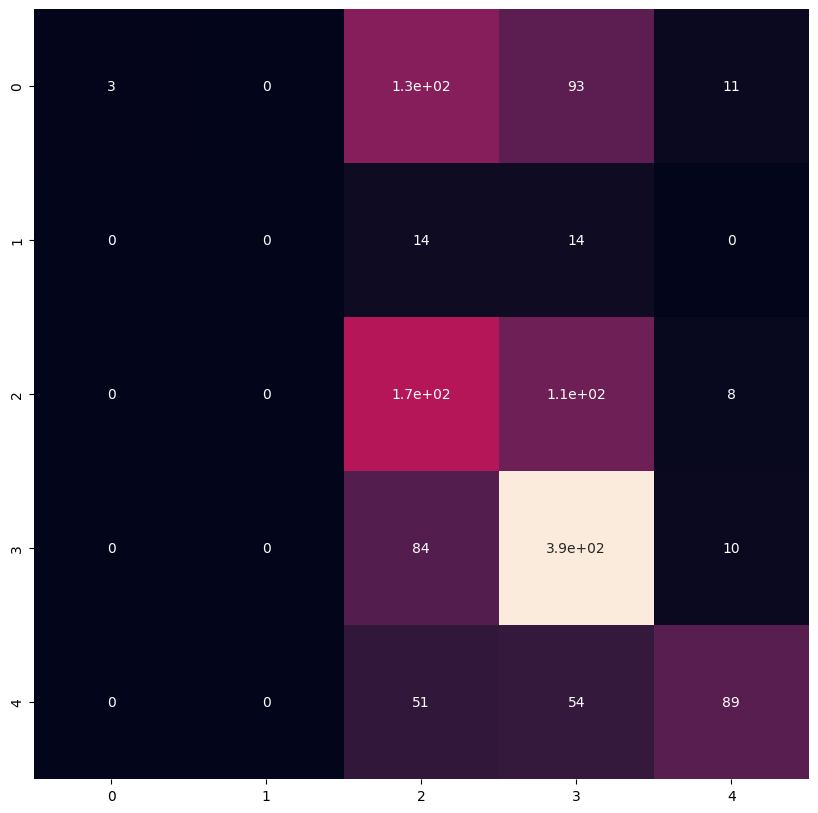

In [37]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(cm, annot = True, cbar = False)

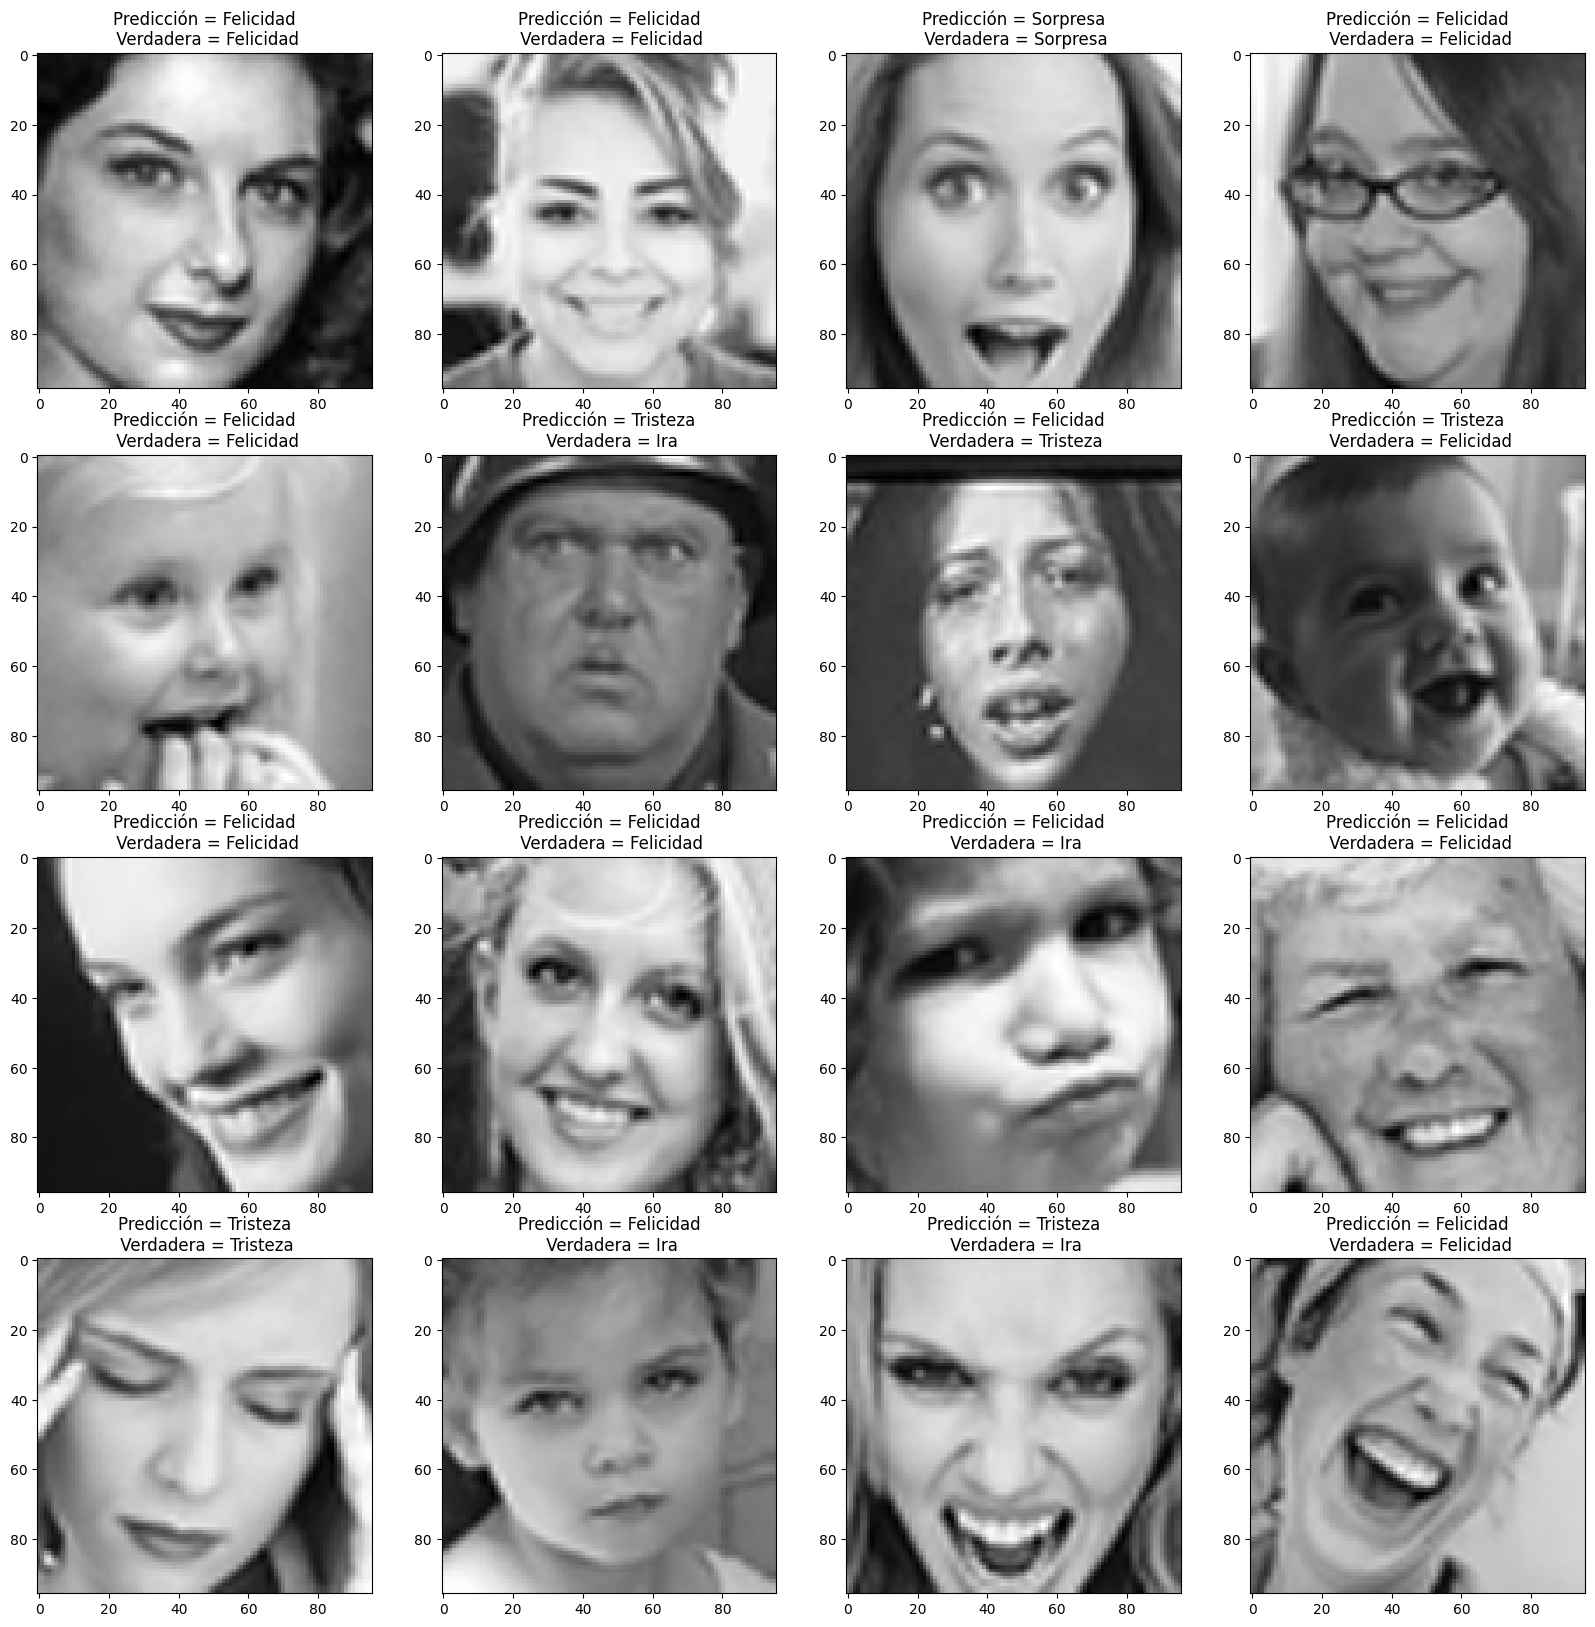

In [38]:
fig = plt.figure(figsize=(20, 20))

for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(X_Test[i],cmap = 'gray')
    plt.title('Predicción = {}\n Verdadera = {}'.format(label_to_text[predicted_classes[i]], label_to_text[y_true[i]]))
    plt.show

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predicted_classes))

              precision    recall  f1-score   support

           0       1.00      0.01      0.02       238
           1       0.00      0.00      0.00        28
           2       0.38      0.60      0.46       288
           3       0.59      0.80      0.68       481
           4       0.75      0.46      0.57       194

    accuracy                           0.53      1229
   macro avg       0.54      0.37      0.35      1229
weighted avg       0.63      0.53      0.47      1229



C:\Users\Adri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Adri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1471: U